In [2]:
# =============================================================================
# SEÇÃO 1: IMPORTAÇÃO DAS BIBLIOTECAS, PREPARAÇÃO E LIMPEZA DOS DADOS
# =============================================================================
## Carregamento e preparação dos dados
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import re
from nltk.corpus import stopwords
import nltk

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('stopwords')
stopwords = stopwords.words('portuguese')

data = pd.read_csv('sample_data/olist_order_reviews_dataset.csv')

#Aqui mantemos somente as colunas que são interessantes para nós
df_model = data[['review_score', 'review_comment_message']].copy()
#E aqui removemos as linhas que não contém comentários escritos nas suas avaliações
df_model.dropna(subset=['review_comment_message'], inplace=True)

#Criamos uma função onde vamos a converter a nota em sentiment

def to_sentiment(score):
  score = int(score)
  if score <= 2:
    return 'negative'
  elif score >= 4:
    return 'positive'
  else:
    return 'neutral'


#Criaremos a coluna de sentimento com base a sua review score

df_model['sentiment'] = df_model['review_score'].apply(to_sentiment)

#Filtramos fora as avaliações 3 estrelas, que estamos considerando como neutras

df_final = df_model[df_model['sentiment'] != 'neutral'].copy()

print("Preparação dos dados concluída.")
print(f"Total de amostras para o modelo: {len(df_final)}")
print(df_final['sentiment'].value_counts())

# Define as variáveis X (features, o texto) e y (target, o sentimento)
X = df_final.review_comment_message
y = df_final.sentiment

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Preparação dos dados concluída.
Total de amostras para o modelo: 37420
sentiment
positive    26530
negative    10890
Name: count, dtype: int64


In [3]:
# =============================================================================
# SEÇÃO 2: DIVISÃO EM DADOS DE TREINO/VALIDAÇÃO E TESTE
# =============================================================================
# Separa 20% dos dados para o teste final
# Os 80% restantes serão usados para treino e cross validation
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# usaremos uma função de pre-processamento para limpar o texto

preprocessor = lambda text: re.sub(r'[^a-zÀ-ú ]', '', str(text).lower())


In [4]:
# SEÇÃO 3: CONSTRUÇÃO DO PIPELINE E OTIMIZAÇÃO USANDO GRIDSEARCHCV
# =============================================================================
# Função de pré-processamento para limpar o texto (remover números, pontuação, etc.)
from sklearn.model_selection import train_test_split, GridSearchCV

# montando o pipeline
pipe = Pipeline([
    ('vec', CountVectorizer(stop_words=stopwords, min_df = 5, preprocessor=preprocessor)), #etapa de vectorização
    ('tfid', TfidfTransformer()),
    ('clf', SGDClassifier(random_state=42)) # garantindo que os resultados do modelo sejam sempre os mesmos com random state definido
])

# Grid de busca para o SGDClassifier
param_grid_sgd = {
    'vec__min_df': [3,5,7,10],
    'vec__ngram_range': [(1, 1)],
    'clf': [SGDClassifier(random_state=42)], # <-- O modelo em si!
    'clf__loss': ['log_loss', 'hinge'],      # <-- Testa Regressão Logística vs. SVM
    'clf__penalty': ['l2', 'l1'],
    'clf__alpha': [1e-2, 5e-3,1e-5]
}

from sklearn.naive_bayes import MultinomialNB

# Grid de busca para o MultinomialNB
param_grid_nb = {
    'vec__ngram_range': [(1, 1), (1, 2)],
    'clf': [MultinomialNB()],                  # usamos diferente modelo
    'clf__alpha': [0.1, 0.5, 1.0]              # parâmetro 'alpha' (smoothing) pertencente ao método Naive Bayes
}

#  criamos uma lista de dicionarios com ambos para inserir no nosso grid search
search_space = [
    param_grid_sgd,
    param_grid_nb
]

# O GridSearchCV com uma lista de grids
grid_search = GridSearchCV(pipe, search_space, cv=5, n_jobs=-1, verbose=1)

print("Iniciando a busca pelo melhor MODELO e seus parâmetros...")

# Usando os dados de treino/validação
grid_search.fit(X_train_val, y_train_val)

print("\nMelhor combinação de modelo e parâmetros encontrada:")
print(grid_search.best_params_)

# Avaliamos o melhor modelo conjunto de teste
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nRelatório de Classificação do MELHOR MODELO no conjunto de TESTE:")
print(classification_report(y_test, y_pred))

Iniciando a busca pelo melhor MODELO e seus parâmetros...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Melhor combinação de modelo e parâmetros encontrada:
{'clf': SGDClassifier(random_state=42), 'clf__alpha': 1e-05, 'clf__loss': 'log_loss', 'clf__penalty': 'l2', 'vec__min_df': 7, 'vec__ngram_range': (1, 1)}

Relatório de Classificação do MELHOR MODELO no conjunto de TESTE:
              precision    recall  f1-score   support

    negative       0.87      0.85      0.86      2191
    positive       0.94      0.95      0.94      5293

    accuracy                           0.92      7484
   macro avg       0.91      0.90      0.90      7484
weighted avg       0.92      0.92      0.92      7484



In [5]:
# =============================================================================
# SEÇÃO 4: AVALIAÇÃO FINAL DO MELHOR MODELO
# =============================================================================
print("\n--- AVALIAÇÃO FINAL DO MELHOR MODELO ---")

# Agora queremos checar se existe overfitting então iremos gerar previsões para os dados de treino e teste para checar
y_pred_train = best_model.predict(X_train_val)
y_pred_test = best_model.predict(X_test)

# Calcula e exibe as acurácias de treino e teste
accuracy_train = accuracy_score(y_train_val, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("\n" + "="*50)
print(f"Acurácia no conjunto de TREINO: {accuracy_train:.4f}")
print(f"Acurácia no conjunto de TESTE:  {accuracy_test:.4f}")
print("="*50)

# Exibe o relatório de classificação completo para o conjunto de teste
print("\nRelatório de Classificação no conjunto de TESTE:")
print(classification_report(y_test, y_pred_test))


--- AVALIAÇÃO FINAL DO MELHOR MODELO ---

Acurácia no conjunto de TREINO: 0.9357
Acurácia no conjunto de TESTE:  0.9200

Relatório de Classificação no conjunto de TESTE:
              precision    recall  f1-score   support

    negative       0.87      0.85      0.86      2191
    positive       0.94      0.95      0.94      5293

    accuracy                           0.92      7484
   macro avg       0.91      0.90      0.90      7484
weighted avg       0.92      0.92      0.92      7484




Gerando Matriz de Confusão para o conjunto de teste...


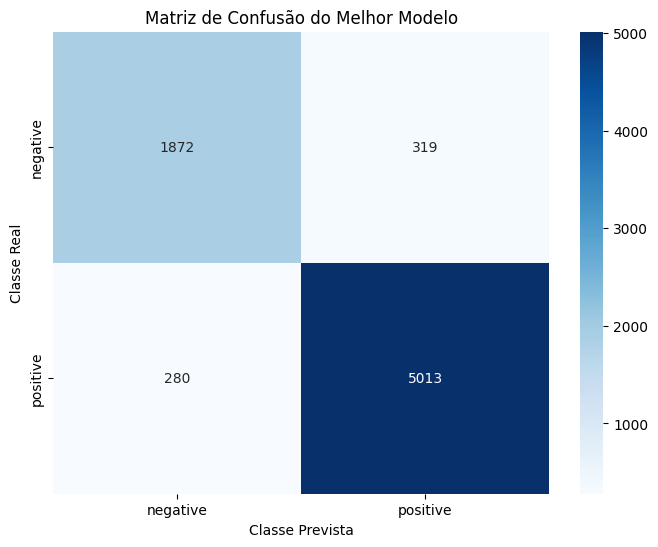


Analisando as palavras mais importantes para o modelo...

--- 20 palavras mais importantes para o sentimento POSITIVO ---


,palavra,peso
117,antes,7.620935
833,excelente,7.182013
2146,ótimo,6.093522
1803,rápida,6.009674
1128,lindo,5.982457
1807,rápido,5.585638
96,amei,5.372141
1460,perfeito,5.370004
2144,ótima,5.048394
44,adorei,5.001103



--- 20 palavras mais importantes para o sentimento NEGATIVO ---


,palavra,peso
1646,péssima,-6.474069
1647,péssimo,-5.280837
474,consigo,-4.942435
1422,passou,-4.918946
1485,pior,-4.592680
1033,inferior,-4.438612
205,baixa,-4.320844
9,absurdo,-4.282675
1267,má,-4.169840
1304,ninguém,-4.101838


In [6]:

# =============================================================================
# SEÇÃO 5: ANÁLISE PROFUNDA DO MELHOR MODELO
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Gerar matriz de confusão para checar onde o modelo está errando mais
print("\nGerando Matriz de Confusão para o conjunto de teste...")
cm = confusion_matrix(y_test, y_pred_test, labels=best_model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Matriz de Confusão do Melhor Modelo')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()


# Também queremos ver o peso que as palavras têm para o modelo avaliar se é review positive ou negative
print("\nAnalisando as palavras mais importantes para o modelo...")
vectorizer = best_model.named_steps['vec']
classifier = best_model.named_steps['clf']
feature_names = np.array(vectorizer.get_feature_names_out())

# Acessa os coeficientes (pesos) que o modelo atribuiu a cada palavra

coeficientes = classifier.coef_[0]
df_importancia = pd.DataFrame({'palavra': feature_names, 'peso': coeficientes})

print("\n--- 20 palavras mais importantes para o sentimento POSITIVO ---")
display(df_importancia.sort_values(by='peso', ascending=False).head(20))

print("\n--- 20 palavras mais importantes para o sentimento NEGATIVO ---")
display(df_importancia.sort_values(by='peso', ascending=True).head(20))



In [7]:

# =============================================================================
# SEÇÃO 6: IDENTIFICAÇÃO DE MOTIVOS
# =============================================================================

# Separa os textos em duas listas: uma para positivos, outra para negativos
textos_positivos = df_final[df_final['sentiment'] == 'positive']['review_comment_message'].tolist()
textos_negativos = df_final[df_final['sentiment'] == 'negative']['review_comment_message'].tolist()

def extrair_top_ngrams(corpus, n=10):
    """Função para extrair os n-grams mais comuns de uma lista de textos."""
    # Usamos o CountVectorizer para contar sequências de 2 e 4 palavras
    vec = CountVectorizer(ngram_range=(3, 4), preprocessor=preprocessor).fit(corpus)

    # Soma as contagens de cada n-gram
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    # Mapeia as contagens para as palavras/frases
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq[:n]

# Extrai e mostra os principais motivos para avaliações positivas
top_positivos = extrair_top_ngrams(textos_positivos, n=15)
print("--- Principais Razões (N-grams) para Avaliações POSITIVAS ---")
display(pd.DataFrame(top_positivos, columns=['Frase', 'Frequência']))

# Extrai e mostra os principais motivos para avaliações negativas
top_negativos = extrair_top_ngrams(textos_negativos, n=15)
print("\n--- Principais Razões (N-grams) para Avaliações NEGATIVAS ---")
display(pd.DataFrame(top_negativos, columns=['Frase', 'Frequência']))

--- Principais Razões (N-grams) para Avaliações POSITIVAS ---


,Frase,Frequência
0,antes do prazo,3780
1,chegou antes do,1150
2,chegou antes do prazo,917
3,dentro do prazo,872
4,bem antes do,818
5,bem antes do prazo,634
6,entregue antes do,592
7,entregue antes do prazo,517
8,entrega antes do,407
9,chegou bem antes,393



--- Principais Razões (N-grams) para Avaliações NEGATIVAS ---


,Frase,Frequência
0,não recebi produto,624
1,não foi entregue,395
2,ainda não recebi,368
3,produto não foi,199
4,até agora não,197
5,prazo de entrega,186
6,não recebi meu,182
7,recebi meu produto,180
8,produto não foi entregue,172
9,ainda não recebi produto,160


In [8]:
# Lista de palavras que indicam que o comentário é sobre QUALIDADE
keywords_qualidade = [
    'qualidade', 'bom', 'excelente', 'perfeito', 'material',
    'funciona', 'bonito', 'otimo', 'gostei', 'resistente', 'acabamento'
]


In [9]:
def extrair_ngrams_por_tema(corpus, palavras_chave, n=10):
    """
    Função para extrair os n-grams mais comuns que contêm
    pelo menos uma das palavras-chave de um tema.
    """
    # Esta parte é igual à função anterior
    vec = CountVectorizer(ngram_range=(3, 4), preprocessor=preprocessor).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # --- A MUDANÇA ESTÁ AQUI ---
    # Filtramos a lista 'words_freq' para manter apenas os n-grams
    # que contêm uma das nossas palavras-chave de qualidade.
    ngrams_filtrados = []
    for frase, freq in words_freq:
        # A função 'any()' verifica se pelo menos uma palavra da lista de keywords está na frase
        if any(palavra in frase for palavra in palavras_chave):
            ngrams_filtrados.append((frase, freq))

    # Ordenamos a lista JÁ FILTRADA para pegar os mais frequentes DENTRO do tema
    ngrams_filtrados = sorted(ngrams_filtrados, key = lambda x: x[1], reverse=True)

    return ngrams_filtrados[:n]

# --- COMO USAR A NOVA FUNÇÃO ---

# Extrai e mostra os principais motivos relacionados à QUALIDADE nas avaliações positivas
top_positivos_qualidade = extrair_ngrams_por_tema(textos_positivos, palavras_chave=keywords_qualidade, n=15)

print("\n--- Principais Elogios sobre a QUALIDADE DO PRODUTO (N-grams) ---")
display(pd.DataFrame(top_positivos_qualidade, columns=['Frase', 'Frequência']))


# Podemos fazer o mesmo para as avaliações negativas para encontrar as críticas à qualidade
keywords_qualidade_negativa = [
    'qualidade', 'ruim', 'defeito', 'fragil', 'quebrado',
    'pessima', 'nao funciona', 'material'
]
top_negativos_qualidade = extrair_ngrams_por_tema(textos_negativos, palavras_chave=keywords_qualidade_negativa, n=15)

print("\n--- Principais Críticas sobre a QUALIDADE DO PRODUTO (N-grams) ---")
display(pd.DataFrame(top_negativos_qualidade, columns=['Frase', 'Frequência']))


--- Principais Elogios sobre a QUALIDADE DO PRODUTO (N-grams) ---


,Frase,Frequência
0,de ótima qualidade,367
1,produto muito bom,364
2,de boa qualidade,302
3,produto de qualidade,286
4,em perfeito estado,269
5,produto de ótima qualidade,220
6,produto de boa qualidade,179
7,muito bom produto,174
8,gostei do produto,156
9,gostei muito do,141



--- Principais Críticas sobre a QUALIDADE DO PRODUTO (N-grams) ---


,Frase,Frequência
0,veio com defeito,103
1,de péssima qualidade,74
2,produto veio com defeito,49
3,produto com defeito,40
4,produto de péssima qualidade,40
5,qualidade do produto,33
6,com defeito não,27
7,de baixa qualidade,26
8,de má qualidade,18
9,veio com defeito não,17
